In [1]:
%load_ext autoreload
%autoreload 2

Imports

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
import pickle
import sys
import seaborn as sns

In [3]:
import os
os.chdir('d:/Users/mokky/Documents/GitHub/nus-iss/PRS-PM-ISY5002-GROUP5/SystemCode')
print(os.getcwd())

d:\Users\mokky\Documents\GitHub\nus-iss\PRS-PM-ISY5002-GROUP5\SystemCode


In [4]:
from datapipeline_uc3 import Datapipeline

In [5]:
# Function to show various error measurement
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = np.mean((forecast - actual)**2)  # MSE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mmape = np.mean(np.abs(forecast - actual) / np.abs(forecast)) # modified mape
    #corr = np.corrcoef(forecast, actual)[0,1]   # corr
    #mins = np.amin(np.hstack([forecast[:,None], 
    #                          actual[:,None]]), axis=1)
    #maxs = np.amax(np.hstack([forecast[:,None], 
    #                          actual[:,None]]), axis=1)
    #minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    #return({'mape':mape, 'me':me, 'mae': mae, 
    #        'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
    #        'corr':corr, 'minmax':minmax})
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'mse':mse, 'rmse':rmse, 'mmape': mmape})

In [6]:
dpl = Datapipeline()

Read raw data from file

In [7]:
dict_hosp_filepaths = {
    'GHL': './Data Exploration/data/uc3/GHL_data_uc3.pkl',
    'MEH': './Data Exploration/data/uc3/MEH_data_uc3.pkl',
    'PEH': './Data Exploration/data/uc3/PEH_data_uc3.pkl',
    'PNH': './Data Exploration/data/uc3/PNH_data_uc3.pkl'}

In [8]:
raw_data_path = './Data Exploration/data/uc3/BillEstimate.csv'
dict_hosp_filepaths = dpl.transform_raw_data(raw_data_path, split_hosp=True)
print(dict_hosp_filepaths)

{'GHL': './Data Exploration/data/uc3/GHL_data_uc3.pkl', 'MEH': './Data Exploration/data/uc3/MEH_data_uc3.pkl', 'PNH': './Data Exploration/data/uc3/PNH_data_uc3.pkl', 'PEH': './Data Exploration/data/uc3/PEH_data_uc3.pkl'}


Creating a train and test dataset.

In [10]:
dict_X_train_file_paths = {}
dict_y_train_file_paths = {}
dict_X_test_file_paths = {}
dict_y_test_file_paths = {}
save_folder_path = None

for hosp in dict_hosp_filepaths:
    if save_folder_path is None:
        save_folder_path = os.path.dirname(dict_hosp_filepaths[hosp])
    X_train_file_paths, y_train_file_path, X_test_file_paths, y_test_file_path = dpl.transform_train_test_data(dict_hosp_filepaths[hosp])
    dict_X_train_file_paths[hosp] = X_train_file_paths
    dict_y_train_file_paths[hosp] = y_train_file_path
    dict_X_test_file_paths[hosp] = X_test_file_paths
    dict_y_test_file_paths[hosp] = y_test_file_path
    
print(dict_X_train_file_paths)
print(dict_y_train_file_paths)
print(dict_X_test_file_paths)
print(dict_y_test_file_paths)

Processing train X rows: 0 ~ 10000
Processing train X rows: 10000 ~ 20000
Processing test X rows: 0 ~ 10000
Processing train X rows: 0 ~ 10000
Processing train X rows: 10000 ~ 20000
Processing test X rows: 0 ~ 10000
Processing train X rows: 0 ~ 10000
Processing train X rows: 10000 ~ 20000
Processing test X rows: 0 ~ 10000
Processing train X rows: 0 ~ 10000
Processing test X rows: 0 ~ 10000
{'GHL': ['./Data Exploration/data/uc3/GHL_data_uc3_X_train_0_uc3.pkl', './Data Exploration/data/uc3/GHL_data_uc3_X_train_1_uc3.pkl'], 'MEH': ['./Data Exploration/data/uc3/MEH_data_uc3_X_train_0_uc3.pkl', './Data Exploration/data/uc3/MEH_data_uc3_X_train_1_uc3.pkl'], 'PNH': ['./Data Exploration/data/uc3/PNH_data_uc3_X_train_0_uc3.pkl', './Data Exploration/data/uc3/PNH_data_uc3_X_train_1_uc3.pkl'], 'PEH': ['./Data Exploration/data/uc3/PEH_data_uc3_X_train_0_uc3.pkl']}
{'GHL': './Data Exploration/data/uc3/GHL_data_uc3_y_train_uc3.pkl', 'MEH': './Data Exploration/data/uc3/MEH_data_uc3_y_train_uc3.pkl', '

In [11]:
dict_df_train_X = {}
dict_df_train_y = {}
dict_df_test_X = {}
dict_df_test_y = {}
for hosp in dict_X_train_file_paths:
    print(hosp)
    dict_df_train_X[hosp] = pd.concat([pd.read_pickle(X_train_file_path)
                                       for X_train_file_path in dict_X_train_file_paths[hosp]])
    print(dict_df_train_X[hosp].shape)
    
    if hosp in dict_y_train_file_paths:
        dict_df_train_y[hosp] = pd.read_pickle(dict_y_train_file_paths[hosp])
        print(dict_df_train_y[hosp].shape)
        
    if hosp in dict_X_test_file_paths:
        dict_df_test_X[hosp] = pd.concat([pd.read_pickle(X_test_file_path)
                                          for X_test_file_path in dict_X_test_file_paths[hosp]])
        print(dict_df_test_X[hosp].shape)

    if hosp in dict_y_test_file_paths:
        dict_df_test_y[hosp] = pd.read_pickle(dict_y_test_file_paths[hosp])
        print(dict_df_test_y[hosp].shape)

GHL
(13922, 55393)
(13922,)
(4641, 55393)
(4641,)
MEH
(16186, 55393)
(16186,)
(5395, 55393)
(5395,)
PNH
(13763, 55393)
(13763,)
(4588, 55393)
(4588,)
PEH
(3016, 55393)
(3016,)
(1006, 55393)
(1006,)


Get feature importance from random forest regressor

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
dict_forest_file_paths = {}
dict_feat_impt_file_paths = {}
dict_df_train_X_new = {}
dict_df_test_X_new = {}
dict_X_train_new_file_paths = {}
dict_X_test_new_file_paths = {}
for hosp in dict_df_train_X:
    forest = RandomForestRegressor(random_state=42, verbose=1, n_jobs=2)
    forest.fit(dict_df_train_X[hosp], dict_df_train_y[hosp])
    
    pkl_file_path = f'{save_folder_path}/{hosp}_forest_model_uc3.pkl'
    with open(pkl_file_path, 'wb') as file:
        pickle.dump(forest, file)
    dict_forest_file_paths[hosp] = pkl_file_path
    
    print(hosp, sum(forest.feature_importances_ > 0.0))
    feature_importance_file_path = f'{save_folder_path}/{hosp}_forest_feat_impt_uc3.npy'
    np.save(feature_importance_file_path, forest.feature_importances_ > 0.0)
    dict_feat_impt_file_paths[hosp] = feature_importance_file_path

    dict_df_train_X_new[hosp] = dict_df_train_X[hosp].loc[:, forest.feature_importances_ > 0.0]
    X_train_new_pkl_file_path = f'{save_folder_path}/{hosp}_new_train_X_uc3.pkl'
    dict_df_train_X_new[hosp].to_pickle(X_train_new_pkl_file_path)
    dict_X_train_new_file_paths[hosp] = X_train_new_pkl_file_path
    print(dict_df_train_X_new[hosp].shape)

    dict_df_test_X_new[hosp] = dict_df_test_X[hosp].loc[:, forest.feature_importances_ > 0.0]
    X_test_new_pkl_file_path = f'{save_folder_path}/{hosp}_new_test_X_uc3.pkl'
    dict_df_test_X_new[hosp].to_pickle(X_test_new_pkl_file_path)
    dict_X_test_new_file_paths[hosp] = X_test_new_pkl_file_path
    print(dict_df_test_X_new[hosp].shape)

print(dict_forest_file_paths)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 10.6min finished


GHL 6599
(13922, 6599)
(4641, 6599)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  6.7min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 14.5min finished


MEH 8337
(16186, 8337)
(5395, 8337)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 12.6min finished


PNH 8092
(13763, 8092)
(4588, 8092)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   43.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.6min finished


PEH 2727
(3016, 2727)
(1006, 2727)
{'GHL': './Data Exploration/data/uc3/GHL_forest_model_uc3.pkl', 'MEH': './Data Exploration/data/uc3/MEH_forest_model_uc3.pkl', 'PNH': './Data Exploration/data/uc3/PNH_forest_model_uc3.pkl', 'PEH': './Data Exploration/data/uc3/PEH_forest_model_uc3.pkl'}


Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression

C:\ProgramData\Anaconda3\envs\prpms\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


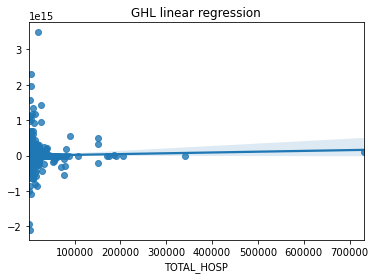

Mean squared error: 14607047271738101848615157760.00
Root Mean squared error: 120859618035711.59
Mean absolute error: 20762742157130.07
{'mape': 5185773534.864889, 'me': 1322107689883.3716, 'mae': 20762742157130.074, 'mpe': -742067647.9514546, 'mse': 1.4607047271738102e+28, 'rmse': 120859618035711.6, 'mmape': 1.4294441145753567}


C:\ProgramData\Anaconda3\envs\prpms\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


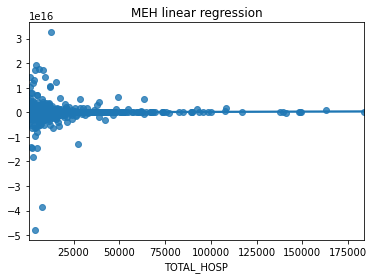

Mean squared error: 1945352185989833309384733622272.00
Root Mean squared error: 1394758827177599.75
Mean absolute error: 193476928985404.12
{'mape': 47492624130.12991, 'me': 13844138321505.064, 'mae': 193476928985404.12, 'mpe': 4764564436.069259, 'mse': 1.9453521859898333e+30, 'rmse': 1394758827177599.8, 'mmape': 1.8857820795992941}


C:\ProgramData\Anaconda3\envs\prpms\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


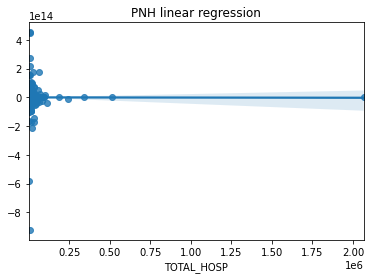

Mean squared error: 524837616828148235833966592.00
Root Mean squared error: 22909334709418.09
Mean absolute error: 3072558189851.35
{'mape': 629821833.6748083, 'me': -45621536265.35258, 'mae': 3072558189851.3496, 'mpe': -31634717.544853814, 'mse': 5.2483761682814824e+26, 'rmse': 22909334709418.086, 'mmape': 1.3173377645418416}


C:\ProgramData\Anaconda3\envs\prpms\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


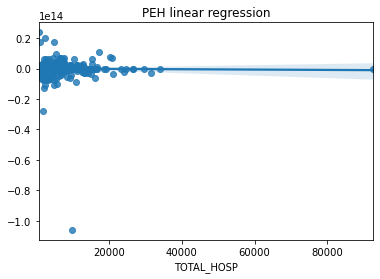

Mean squared error: 16428586716148742072827904.00
Root Mean squared error: 4053219302745.50
Mean absolute error: 812012013440.36
{'mape': 257628076.74918687, 'me': -43834917398.95521, 'mae': 812012013440.3643, 'mpe': 16490744.830694312, 'mse': 1.6428586716148742e+25, 'rmse': 4053219302745.503, 'mmape': 1.515013978943016}


In [20]:
for hosp in dict_df_train_X_new:
    model = LinearRegression(n_jobs=2)
    model.fit(dict_df_train_X_new[hosp], dict_df_train_y[hosp])

    # save model to file
    pickle.dump(model, open(f'{save_folder_path}/{hosp}_uc3_linreg_model_pkl.sav', 'wb'))
    
    y_pred = model.predict(dict_df_test_X_new[hosp])
    sns.regplot(dict_df_test_y[hosp],y_pred).set_title(f'{hosp} linear regression')
    plt.show()
    
    # MSE
    print('Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],y_pred, squared=True))

    # RMSE
    print('Root Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],y_pred, squared=False))

    # MAE
    print('Mean absolute error: %.2f'
          % mean_absolute_error(dict_df_test_y[hosp],y_pred))
    
    print(forecast_accuracy(y_pred, dict_df_test_y[hosp]))

Neural Networks ( Sequential )

In [ ]:
n_hid_nodes = 4096
dropout_rate = 0.2
rand_seed = 42
kernel_init = 'he_normal'
hid_act = 'relu'
n_layers = 2
epoch=100

In [ ]:
for hosp in dict_df_train_X_new:
    NN_model = Sequential(name=f'{hosp}_{n_layers+1}layers_{n_hid_nodes}_nodes')
    NN_model.add(Dense(n_hid_nodes,
                       kernel_initializer=kernel_init,
                       input_dim = dict_df_train_X_new[hosp].shape[1], 
                       activation=hid_act))
    NN_model.add(Dropout(dropout_rate,
                         seed=rand_seed))
    for i in range(n_layers):
        NN_model.add(Dense(n_hid_nodes, kernel_initializer=kernel_init))
        NN_model.add(BatchNormalization())
        NN_model.add(Activation(hid_act))
        NN_model.add(Dropout(dropout_rate, seed=rand_seed))
        
    NN_model.add(Dense(1, kernel_initializer=kernel_init,activation='linear'))
    
    NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    print(NN_model.summary())
    
    checkpoint_name = f'{hosp}_NN2_Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    callbacks_list = [es, checkpoint]
    
    NN_model.fit(dict_df_train_X_new[hosp], dict_df_train_y[hosp],
                 epochs=100, batch_size=128, validation_split = 0.2,
                 callbacks=callbacks_list)

    # save model to file
    NN_model.save(f'{save_folder_path}/{hosp}_uc3_NN2_model.h5')
    
    predictions = NN_model.predict(dict_df_test_X_new[hosp])
    
    sns.regplot(x=dict_df_test_y[hosp], y=predictions).set_title(NN_model.name)
    plt.show()
    
    # MSE
    print('Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],predictions, squared=True))

    # RMSE
    print('Root Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],predictions, squared=False))

    # MAE
    print('Mean absolute error: %.2f'
          % mean_absolute_error(dict_df_test_y[hosp],predictions))
    
    print(forecast_accuracy(predictions.reshape((-1,)), dict_df_test_y[hosp]))

Random forest

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  8.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
C:\ProgramData\Anaconda3\envs\prpms\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


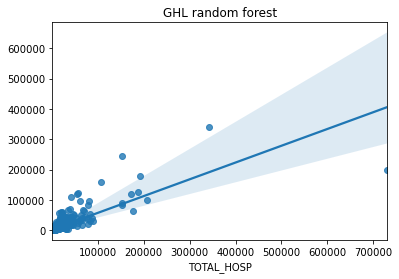

Mean squared error: 90306199.45
Root Mean squared error: 9502.96
Mean absolute error: 1957.23
{'mape': 0.3129581771248545, 'me': -536.5070705125637, 'mae': 1957.2345707564564, 'mpe': 0.09387623717255378, 'mse': 90306199.44521524, 'rmse': 9502.95740520893, 'mmape': 0.3024455103435458}


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  7.5min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 16.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished
C:\ProgramData\Anaconda3\envs\prpms\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


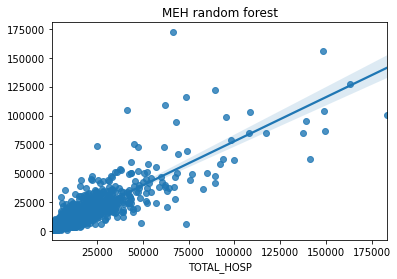

Mean squared error: 26931022.62
Root Mean squared error: 5189.51
Mean absolute error: 2170.91
{'mape': 0.33415164260101193, 'me': -450.37842199465257, 'mae': 2170.9122063677346, 'mpe': 0.11080041655822871, 'mse': 26931022.617666107, 'rmse': 5189.510826433076, 'mmape': 0.3172748773179964}


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 14.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
C:\ProgramData\Anaconda3\envs\prpms\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


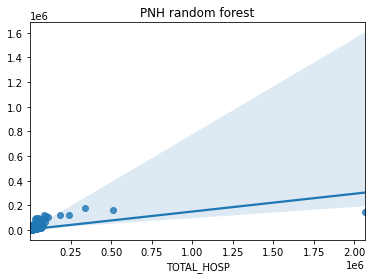

Mean squared error: 858300412.95
Root Mean squared error: 29296.76
Mean absolute error: 2680.71
{'mape': 0.3438357675434181, 'me': -819.0324886919198, 'mae': 2680.711351418305, 'mpe': 0.11903880495544382, 'mse': 858300412.9460866, 'rmse': 29296.764547405004, 'mmape': 0.3142965500484379}


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   34.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\ProgramData\Anaconda3\envs\prpms\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


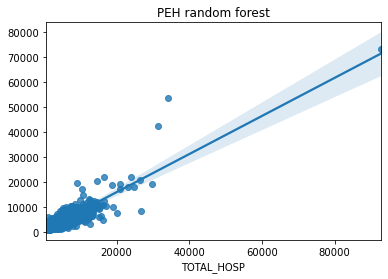

Mean squared error: 5323939.07
Root Mean squared error: 2307.37
Mean absolute error: 1392.19
{'mape': 0.3299286898775644, 'me': -349.1789907670645, 'mae': 1392.1939147564613, 'mpe': 0.08212525599227384, 'mse': 5323939.070279472, 'rmse': 2307.366262707217, 'mmape': 0.32477022569259084}


In [25]:
for hosp in dict_df_train_X_new:
    model = RandomForestRegressor(random_state=42, verbose=1, n_jobs=2)
    model.fit(dict_df_train_X_new[hosp],dict_df_train_y[hosp])

    # save model to file
    pickle.dump(model, open(f'{save_folder_path}/{hosp}_uc3_rfreg_model_pkl.sav', 'wb'))
    
    predicted_forest = model.predict(dict_df_test_X_new[hosp])
    
    sns.regplot(dict_df_test_y[hosp],predicted_forest).set_title(f'{hosp} random forest')
    plt.show()
    
    # MSE
    print('Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],predicted_forest, squared=True))

    # RMSE
    print('Root Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],predicted_forest, squared=False))

    # MAE
    print('Mean absolute error: %.2f'
          % mean_absolute_error(dict_df_test_y[hosp],predicted_forest))
    
    print(forecast_accuracy(predicted_forest, dict_df_test_y[hosp]))

XG Boost

In [26]:
for hosp in dict_df_train_X_new:
    XGBModel = XGBRegressor(random_state=42, verbosity=1, n_jobs=2)
    XGBModel.fit(dict_df_train_X_new[hosp],dict_df_train_y[hosp] , verbose=True)

    # save model to file
    pickle.dump(model, open(f'{save_folder_path}/{hosp}_uc3_xgbreg_model_pkl.sav', 'wb'))
    
    XGBpredictions = XGBModel.predict(dict_df_test_y[hosp])
    
    sns.regplot(dict_df_test_y[hosp],XGBpredictions).set_title(f'{hosp} xg boost')
    plt.show()
    
    # MSE
    print('Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],XGBpredictions, squared=True))

    # RMSE
    print('Root Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],XGBpredictions, squared=False))

    # MAE
    print('Mean absolute error: %.2f'
          % mean_absolute_error(dict_df_test_y[hosp],XGBpredictions))
    
    print(forecast_accuracy(XGBpredictions, dict_df_test_y[hosp]))

ValueError: ('Expecting 2 dimensional numpy.ndarray, got: ', (4641,))